# **Análisis de los factores determinantes en el precio de las propiedades inmobiliarias en EE. UU. para inversionistas y agentes inmobiliarios**
**David Maya Londoño**

El mercado inmobiliario de Estados Unidos es altamente complejo y requiere considerar múltiples factores al momento de tasar una propiedad. En este contexto, se plantea el análisis de datos para responder a las siguientes preguntas objetivo:

* ¿Cuáles son las propiedades con la mejor relación precio-características (área, número de habitaciones y baños) y ubicación (estado, código postal) para inversionistas y agentes inmobiliarios?
* ¿Cuáles son los principales factores que afectan el precio de una vivienda?
A través del análisis y la validación estadística de los modelos entrenados, se busca establecer una hipótesis que permita predecir el precio de una vivienda a partir de los parámetros mencionados anteriormente, lo que resulta relevante para los agentes inmobiliarios e inversionistas en la toma de decisiones de inversión.

En este trabajo, se plantea la hipótesis de que es posible predecir el precio de una vivienda en el mercado inmobiliario estadounidense utilizando las características de la propiedad (como su área, número de dormitorios y baños) y su ubicación (estado y código postal). Además, se pretende identificar los factores más relevantes que influyen en el precio de una vivienda. Estos resultados pueden ser de gran interés para los agentes inmobiliarios e inversionistas que buscan tomar decisiones informadas en el mercado de bienes raíces. Se presenta un análisis estadístico y modelos de predicción validados que permiten responder a estas preguntas.

---
# **Instalación de Librerías y Creación de funciones**
---

##Instalación de Librerías

In [66]:
#!pip install https://github.com/ydataai/ydata-profiling/archive/master.zip --quiet
!pip install plotly-geo --quiet
!pip install geopandas --quiet
!pip install pyshp --quiet
!pip install shapely --quiet
!pip install pingouin --quiet

## Importación de Librerías

In [67]:
import base64
import random
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.stats import linregress, skew, kurtosis, ttest_ind, boxcox, yeojohnson
import jinja2
import json
import os
from urllib.request import urlopen
import requests
import pingouin as pg
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np

##Creación de Funciones

In [68]:
# Funcion de Descargador de OneDrive

def descargador_OneDrive (link_OneDrive):
    datos_bytes64 = base64.b64encode(bytes(link_OneDrive, 'utf-8'))
    datos_bytes64_String = datos_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    Url_final = f"https://api.onedrive.com/v1.0/shares/u!{datos_bytes64_String}/root/content"
    return Url_final


# ------------------------------------------------------------------------------
# Funcion de Ploteo en Seaborn

def subplots_y_plots(columna_plot, titulo_figura, etiqueta_x, etiqueta_y, titulo_histo, titulo_boxplot):
    # Crear un diseño de subplots con 1 fila y 2 columnas
    fig, axs = plt.subplots(ncols=2, figsize=(6, 3))

    # Displot de seaborn de la columna
    sns.histplot(columna_plot, kde=True, ax=axs[0])
    axs[0].set_title(titulo_histo)
    axs[0].set_xlabel(etiqueta_x)
    axs[0].set_ylabel(etiqueta_y)

    # Boxplot de seaborn de la columna
    sns.boxplot(x=columna_plot, orient='h', ax=axs[1])
    axs[1].set_title(titulo_boxplot)
    axs[1].set_xlabel(etiqueta_x)

    # Título de la figura
    fig.suptitle(titulo_figura)

    # Ajustar el espacio entre los subplots para que no se superpongan
    fig.tight_layout()

    #Mostrar la figura
    plt.show()


# ------------------------------------------------------------------------------
# Funcion de análisis de Columna

def analisis_columna(df, columna, plot="no"):
    # Separación de la columna y eliminación de los valores faltantes
    columna_analisis = df[columna].dropna()

    # Análisis antes del data wrangling
    print('\033[1m' + f'VALORES ANTES DEL DATA WRANGLING DE {columna}' + '\033[0m', "\n")

    # Ploteo solo si el argumento plot es "yes"
    if plot == "yes":
        subplots_y_plots(columna_plot=columna_analisis,
                         titulo_figura=f'ANÁLISIS ANTES DEL DATA WRANGLING DE {columna}',
                         etiqueta_x=f'Valores de {columna}',
                         etiqueta_y='Frecuencia',
                         titulo_histo=f'Distribución de {columna}',
                         titulo_boxplot=f'Boxplot de {columna}')

    # Calculo de los límites para la columna
    q1, q3 = columna_analisis.quantile([0.25, 0.75])
    iqr = q3 - q1

    #print("OJO CON ESTO: ", columna_analisis.min())

    # Utilizar función lambda para actualizar límite inferior si es menor que el valor mínimo de la columna
    limite_inf = (lambda x, y: x if x < y else y)(q1 - 1.5 * iqr, columna_analisis.min())
    limite_sup = q3 + 1.5 * iqr

    #Imprimir los valores actuales (raw)
    print("\nSkewness: " , skew(columna_analisis),
          "\nKurtosis: ", kurtosis(columna_analisis, fisher=False),
          f"\nLímite Inferior de {columna}: ", limite_inf,
          f"\nLímite Superior de {columna}: ", limite_sup,
          "\n\nESTADÍSTICA DESCRIPTIVA: \n\n", columna_analisis.describe(),
          "\n\n", '\033[96m' + '-' * 100 + '\033[0m', "\n")

    # Análisis después del data wrangling
    # Aplicación de los límites en la Columna
    columna_analisis = columna_analisis[(columna_analisis >= limite_inf) & (columna_analisis < limite_sup)]

    print('\033[1m' + f'VALORES DESPUES DEL DATA WRANGLING A {columna}' + '\033[0m', "\n")

    # Ploteo solo si el argumento plot es "yes"
    if plot == "yes":
        subplots_y_plots(columna_plot=columna_analisis,
                         titulo_figura=f'ANÁLISIS DESPUES DEL DATA WRANGLING DE {columna}',
                         etiqueta_x=f'Valores de {columna}',
                         etiqueta_y='Frecuencia',
                         titulo_histo=f'Distribución de {columna}',
                         titulo_boxplot=f'Boxplot de {columna}')

    # Imprimir los nuevos valores estadísticos
    print("\nSkewness: " , skew(columna_analisis),
          "\nKurtosis: ", kurtosis(columna_analisis, fisher=False),
          f"\n\nESTADÍSTICA DESCRIPTIVA DE {columna}: \n\n", columna_analisis.describe() )
    return limite_inf, limite_sup


# ------------------------------------------------------------------------------
# Funcion de Test de Normalidad
#H0, que la variable se distribuye normalmente
#H1, que la variable no se distirbuye normalmente
#H0, que la variable se distribuye normalmente
#H1, que la variable no se distirbuye normalmente
def test_normality(variable, alpha=0.05):
    k, pvalue = stats.normaltest(variable)
    if pvalue < alpha:
        hipotesis = "Hipotesis alternativa - La variable no se distribuye normalmente"
    else:
        hipotesis = "Hipotesis nula - La variable se distribuye normalmente"
    print(f"Variable: {variable.name}\n{hipotesis}\np-value: {pvalue:.4f}")


# Funcion de prueba T
def ttest_price_by_columns(columna1, columna2):
    high_mean = df[df[columna1] >= df[columna1].median()]
    low_mean = df[df[columna1] < df[columna1].median()]


    t_stat, p_value = ttest_ind(high_mean[columna2], low_mean[columna2])

    print("\033[1;36m-----PRUEBA T PARA EL GRUPO DE", columna1, "CON", columna2, "-----\033[0m")
    print("MEDIA DEL GRUPO", columna2, "CON", columna1, "MAYOR O IGUAL A LA MEDIANA:", high_mean[columna2].mean())
    print("MEDIA DEL GRUPO", columna2, "CON", columna1, "MENOR A LA MEDIANA:", low_mean[columna2].mean())
    print("T-Statistic:", t_stat)
    print("P-Value:", p_value)

    alpha = 0.05
    if p_value < alpha:
        print("\033[1;32m\nSe rechaza la hipótesis nula, las variables presentan correlación\n\033[0m")
    else:
        print("\033[1;31m\nNo se puede rechazar la hipótesis nula\n\033[0m")
    print("\033[1;36m-------------------------------------------------------------------------\n\n\033[0m")


# Llamado de los Json para los ZIP Codes
url = 'https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/nj_new_jersey_zip_codes_geo.min.json'
with urlopen(url) as response:
    nj_zip_json = json.load(response)

zip_code = []
for i in range(len(nj_zip_json['features'])):
    code = nj_zip_json['features'][i]['properties']['ZCTA5CE10']
    zip_code.append(code)

# Diccionario con los códigos de los estados de USA
estados = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Virgin Islands': 'VI',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


---
# **Apertura del Datset**
---

**Diccionario de datos:**

* STATUS: Indica si el inmueble está en venta o listo para construir.
* HABITACIONES: El número de dormitorios disponibles en la propiedad.
* WC: este es el número de baños disponibles en la propiedad.
* AREA_LOTE: tamaño de la parcela en acres
* AREA_CASA: El tamaño de la propiedad en pies cuadrados
* DIRECCION: dirección completa del inmueble.
* CALLE: dirección del inmueble.
* CIUDAD: la ciudad de la propiedad.
* ESTADO: estado de la propiedad
* ZIP_CODE: Código postal del inmueble.
* PRECIO: es el valor de la propiedad en dólares.
* FECHA_VENTA: Fecha de venta del inmueble

In [6]:
# Se descarga el dataset de Onedrive
url_truncada = "https://1drv.ms/u/s!AsXv0py_horRoB6RupXjVZhrn4uP?e=876rmT"
url_directa = descargador_OneDrive(url_truncada)
dataset_raw = pd.read_csv(url_directa, sep = ",")

# Cambio de los nombres de las columnas
dataset_raw = dataset_raw.set_axis(['STATUS', 'PRECIO', 'HABITACIONES', 'WC', 'AREA_LOTE', 'DIRECCION', 'CALLE', 'CIUDAD', 'ESTADO', 'ZIP_CODE', 'AREA_CASA', 'FECHA_VENTA'], axis=1)

# Organización de las columnas
dataset_raw = pd.DataFrame(dataset_raw, columns=['STATUS', 'HABITACIONES', 'WC', 'AREA_LOTE', 'AREA_CASA', 'DIRECCION', 'CALLE', 'CIUDAD', 'ESTADO', 'ZIP_CODE', 'PRECIO', 'FECHA_VENTA'])

# Randomizacion
dataset_random = dataset_raw.sample(frac=1, random_state=random.seed())  # random_state asegura la reproductibilidad
dataset_random.index = np.arange(dataset_random.index.size)

# Guardarlo en CSV
#dataset_random.to_csv('Dataset_Realtor.csv', index=False)

dataset_random.head(-20)



,STATUS,HABITACIONES,WC,AREA_LOTE,AREA_CASA,DIRECCION,CALLE,CIUDAD,ESTADO,ZIP_CODE,PRECIO,FECHA_VENTA
0,for_sale,3.0,3.0,10.88,2498.0,"291 Millbury St, Auburn, MA, 01501",291 Millbury St,Auburn,Massachusetts,1501.0,779800.0,2002-03-15
1,for_sale,NaN,NaN,1.11,NaN,"Aspen Dr Lot 8, South Thomaston, ME, 04858",Aspen Dr Lot 8,South Thomaston,Maine,4858.0,43000.0,NaN
2,for_sale,1.0,1.0,NaN,NaN,"166 E 35th St Apt 6C, New York, NY, 10016",166 E 35th St Apt 6C,New York,New York,10016.0,460000.0,2008-07-22
3,for_sale,2.0,2.0,NaN,820.0,"181 Hudson St Ste 2D, New York, NY, 10013",181 Hudson St Ste 2D,New York,New York,10013.0,2350000.0,2020-07-09
4,for_sale,4.0,5.0,0.49,4026.0,"109 Old Stow Rd, Concord, MA, 01742",109 Old Stow Rd,Concord,Massachusetts,1742.0,1595000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
923134,for_sale,NaN,NaN,17.30,NaN,"18 Hidden Valley Rd, Shaftsbury, VT, 05262",18 Hidden Valley Rd,Shaftsbury,Vermont,5262.0,35000.0,NaN
923135,for_sale,5.0,6.0,0.26,NaN,"10 Ardsley Rd, Glen Ridge, NJ, 07028",10 Ardsley Rd,Glen Ridge,New Jersey,7028.0,1349000.0,2019-11-20
923136,for_sale,5.0,6.0,0.51,6137.0,"130 Great Plain Ave, Wellesley, MA, 02482",130 Great Plain Ave,Wellesley,Massachusetts,2482.0,2995000.0,1983-09-01
923137,for_sale,2.0,2.0,NaN,NaN,"104-21 39 Ave Unit 4D, Corona, NY, 11368",104-21 39 Ave Unit 4D,Corona,New York,11368.0,488000.0,NaN


---
# **Exploración del Dataset**
---

In [69]:
#Info del dataset
print("\033[91mINFORMACIÓN DEL DATASET\n\033[0m")
dataset_raw.info()

#Revision Datos Nulos
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nCONTEO DE REGISTROS NULOS \n\n\033[0m", dataset_raw.isnull().sum())

# Valores de STATUS
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nVALORES UNICOS DE LA COLUMNA STATUS \n\n\033[0m", dataset_raw['STATUS'].unique())

# Valores de WC
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nVALORES UNICOS DE LA COLUMNA BAÑOS \n\n\033[0m", dataset_raw['WC'].unique())

# Valores de HABITACIONES
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nVALORES UNICOS DE LA COLUMNA HABITACIONES \n\n\033[0m", dataset_raw['HABITACIONES'].unique())

# Valores de ESTADOS
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nVALORES UNICOS DE LA COLUMNA ESTADOS \n\n\033[0m", dataset_raw['ESTADO'].unique())

#Revisamos direcciones duplicadas
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nDIRECCIONES DUPLICADAS \n\n\033[0m", dataset_raw.duplicated(subset="DIRECCION"))
#dataset_raw.duplicated(subset="DIRECCION")

# Realizamos una análisis estadístico descriptivo
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nESTADÍSTICA DERSCRIPTIVA \n\n\033[0m")
dataset_raw[['PRECIO', 'HABITACIONES', 'WC', 'AREA_LOTE', 'AREA_CASA']].describe()


INFORMACIÓN DEL DATASET

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923159 entries, 0 to 923158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   STATUS        923159 non-null  object 
 1   HABITACIONES  791456 non-null  float64
 2   WC            807967 non-null  float64
 3   AREA_LOTE     649536 non-null  float64
 4   AREA_CASA     625316 non-null  float64
 5   DIRECCION     923159 non-null  object 
 6   CALLE         921021 non-null  object 
 7   CIUDAD        923085 non-null  object 
 8   ESTADO        923159 non-null  object 
 9   ZIP_CODE      922954 non-null  float64
 10  PRECIO        923088 non-null  float64
 11  FECHA_VENTA   456396 non-null  object 
dtypes: float64(6), object(6)
memory usage: 84.5+ MB

----------------------------------------------------------------------------------------------------
 
CONTEO DE REGISTROS NULOS 

 STATUS               0
HABITACIONES    131703
WC              

,PRECIO,HABITACIONES,WC,AREA_LOTE,AREA_CASA
count,9.230880e+05,791456.000000,807967.000000,649536.000000,6.253160e+05
mean,8.841225e+05,3.330352,2.488164,17.075888,2.141644e+03
std,2.623745e+06,2.070402,1.940057,962.322866,3.035327e+03
min,0.000000e+00,1.000000,1.000000,0.000000,1.000000e+02
25%,2.690000e+05,2.000000,1.000000,0.110000,1.130000e+03
50%,4.750000e+05,3.000000,2.000000,0.290000,1.651000e+03
75%,8.399000e+05,4.000000,3.000000,1.150000,2.499000e+03
max,8.750000e+08,123.000000,198.000000,100000.000000,1.450112e+06




---
# **Data Wrangling**
---



##LIMPIEZA DEL DATASET

### Limpieza de Nulos

In [70]:
import warnings
warnings.filterwarnings('ignore')

#Realizamos copia del dataset en uno nuevo a limpiar
df_etl = dataset_random.copy()

# Eliminacion de los registros que tengan el STATUS de "ready_to_buid" ya que sólo nos interesan las viviendas construidas
df_etl.drop(df_etl[df_etl['STATUS'] == 'ready_to_build'].index, inplace=True)

# Eliminamos la columna STATUS, CALLE, FECHA_VENTA
df_etl.drop(["STATUS", "CALLE", "FECHA_VENTA"], axis=1, inplace=True)

# Eliminamos los registros que cumplan la condición de tener valores nulos en ZIP_CODE & CIUDAD & DIRECCION
df_etl.dropna(subset=['CIUDAD', 'ZIP_CODE', 'DIRECCION'], inplace=True)

# Rellena los valores nulos en la columna 'ZIP_CODE '
df_etl['ZIP_CODE'] = df_etl.groupby(['DIRECCION', 'CIUDAD'])['ZIP_CODE'].apply(lambda x: x.ffill().bfill())
df_etl['ZIP_CODE'] = df_etl.groupby(['DIRECCION'])['ZIP_CODE'].apply(lambda x: x.ffill().bfill())


#-----------------------------------------------------------------------------------------------
# RELLENADO DE VALORES NULOS EN LAS COLUMNAS 'HABITACIONES', 'WC', 'AREA_CASA', 'AREA_LOTE' SI
# EXISTE UNA DIRECCION DUPLICADA QUE CONTENGA DATOS
#------------------------------------------------------------------------------------------------

# Definiendo las columnas a rellenar
columnas_a_rellenar = ['HABITACIONES', 'WC', 'AREA_CASA', 'AREA_LOTE']

# Creando un DataFrame temporal con las columnas a rellenar
df_temporal = df_etl[columnas_a_rellenar]

# Aplicando la transformación de grupo a todo el DataFrame temporal
df_temporal = df_etl.groupby('DIRECCION')[columnas_a_rellenar].transform(lambda grupo: grupo.ffill().bfill())

# Reemplazando las columnas originales con las transformadas
df_etl[columnas_a_rellenar] = df_temporal

# Eliminando las direcciones duplicadas, manteniendo la primera ocurrencia de cada una
df_etl = df_etl.drop_duplicates(subset='DIRECCION')

#----------------------------------------------------------------------------------------------------
# OTRAS TAREAS
#----------------------------------------------------------------------------------------------------

# Eliminación de los Registros Nulos Finales
df_etl.dropna(subset=['ZIP_CODE', 'PRECIO'], inplace=True)
df_etl.drop_duplicates(subset=['DIRECCION'], inplace=True)
df_etl.drop("DIRECCION", axis=1, inplace=True)
df_etl.dropna(subset=['HABITACIONES', 'WC', 'AREA_LOTE', 'AREA_CASA'], how='all', inplace=True)

#Revision Datos Nulos
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nCONTEO DE REGISTROS NULOS \n\n\033[0m", df_etl.isnull().sum())


----------------------------------------------------------------------------------------------------
 
CONTEO DE REGISTROS NULOS 

 HABITACIONES    16447
WC              15020
AREA_LOTE       29800
AREA_CASA       35084
CIUDAD              0
ESTADO              0
ZIP_CODE            0
PRECIO              0
dtype: int64


### Imputacion

In [71]:
from sklearn.impute import KNNImputer

# Imputando los valores nulos en las columnas "HABITACIONES" y "WC" utilizando la mediana
df_etl['HABITACIONES'].fillna(df_etl['HABITACIONES'].median(), inplace=True)
df_etl['WC'].fillna(df_etl['WC'].median(), inplace=True)

# Creando el imputador KNN
imputador_knn = KNNImputer(n_neighbors=5)

# Aplicando la imputación KNN a las columnas "AREA_LOTE" y "AREA_CASA"
df_etl[['AREA_LOTE', 'AREA_CASA']] = imputador_knn.fit_transform(df_etl[['AREA_LOTE', 'AREA_CASA']])

#Revision Datos Nulos
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nCONTEO DE REGISTROS NULOS \n\n\033[0m", df_etl.isnull().sum(), "\n")


----------------------------------------------------------------------------------------------------
 
CONTEO DE REGISTROS NULOS 

 HABITACIONES    0
WC              0
AREA_LOTE       0
AREA_CASA       0
CIUDAD          0
ESTADO          0
ZIP_CODE        0
PRECIO          0
dtype: int64 



In [72]:
# Reorganizamos el index
df_etl.index = np.arange(df_etl.index.size)

# Conversión de datos a tipo entero
df_etl["HABITACIONES"] = df_etl["HABITACIONES"].astype(int)
df_etl["WC"] = df_etl["WC"].astype(int)
df_etl["ZIP_CODE"] = df_etl["ZIP_CODE"].astype(int)
df_etl["ZIP_CODE"] = df_etl["ZIP_CODE"].astype(str).str.zfill(5)
df_etl["ESTADO"] = df_etl["ESTADO"].astype(str)

#Revision Datos Nulos
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\033[91m\nCONTEO DE REGISTROS NULOS \n\n\033[0m", df_etl.isnull().sum(), "\n")

df_etl.head(-20)



----------------------------------------------------------------------------------------------------
 
CONTEO DE REGISTROS NULOS 

 HABITACIONES    0
WC              0
AREA_LOTE       0
AREA_CASA       0
CIUDAD          0
ESTADO          0
ZIP_CODE        0
PRECIO          0
dtype: int64 



,HABITACIONES,WC,AREA_LOTE,AREA_CASA,CIUDAD,ESTADO,ZIP_CODE,PRECIO
0,3,3,10.880000,2498.000000,Auburn,Massachusetts,01501,779800.0
1,3,2,1.110000,2836.400000,South Thomaston,Maine,04858,43000.0
2,1,1,17.833789,2159.934538,New York,New York,10016,460000.0
3,2,2,0.196000,820.000000,New York,New York,10013,2350000.0
4,4,5,0.490000,4026.000000,Concord,Massachusetts,01742,1595000.0
...,...,...,...,...,...,...,...,...
111561,4,3,0.260000,2187.000000,Lynbrook,New York,11563,728000.0
111562,3,2,1.360000,2435.000000,Warren,Maine,04864,79900.0
111563,3,1,0.030000,1138.000000,Philadelphia,Pennsylvania,19125,275000.0
111564,4,4,3.000000,4932.000000,Colts Neck,New Jersey,07722,1544995.0


In [73]:
# Tomar los primeros 10000 registros
primeros_registros = df_etl.head(10000)

# Guardarlo en CSV
primeros_registros.to_csv('Dataset_Realtor.csv', index=False)

##ELIMINACIÓN DE OUTLIERS

### Eliminación de registros incoherentes

Eliminación de registros incoherentes basándonos en la relación entre habitaciones y baños (WC). Utilizaremos un umbral definido como la media ± 2 desviaciones estándar para identificar los registros incoherentes.

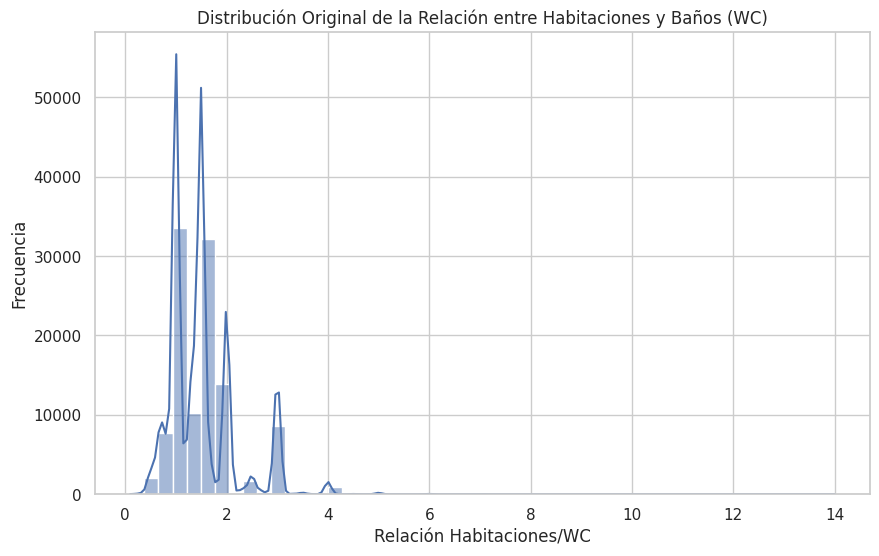

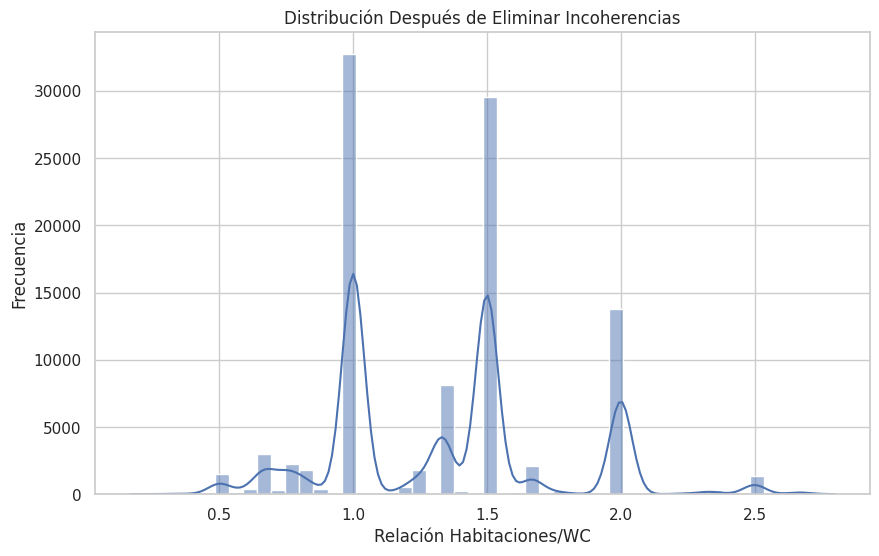

Estadísticas originales:
count    111586.000000
mean          1.492675
std           0.666292
min           0.100000
25%           1.000000
50%           1.500000
75%           1.666667
max          14.000000
Name: RELACION_HABITACIONES_WC, dtype: float64

Estadísticas después de eliminar incoherencias:
count    101715.000000
mean          1.332750
std           0.421033
min           0.166667
25%           1.000000
50%           1.333333
75%           1.500000
max           2.800000
Name: RELACION_HABITACIONES_WC, dtype: float64


In [74]:
# Copia del dataset
df_ol = df_etl.copy()

# Calculando la relación entre habitaciones y baños (WC)
df_ol['RELACION_HABITACIONES_WC'] = df_ol['HABITACIONES'] / df_ol['WC']

# Visualizando la distribución original de la relación entre habitaciones y baños
plt.figure(figsize=(10, 6))
sns.histplot(df_ol['RELACION_HABITACIONES_WC'], bins=50, kde=True)
plt.title('Distribución Original de la Relación entre Habitaciones y Baños (WC)')
plt.xlabel('Relación Habitaciones/WC')
plt.ylabel('Frecuencia')
plt.show()

# Calculando los umbrales para considerar registros incoherentes
umbral_inferior = df_ol['RELACION_HABITACIONES_WC'].mean() - 2 * df_ol['RELACION_HABITACIONES_WC'].std()
umbral_superior = df_ol['RELACION_HABITACIONES_WC'].mean() + 2 * df_ol['RELACION_HABITACIONES_WC'].std()

# Eliminando los registros incoherentes basados en los umbrales
df_ol_coherente = df_ol[(df_ol['RELACION_HABITACIONES_WC'] >= umbral_inferior) &
                  (df_ol['RELACION_HABITACIONES_WC'] <= umbral_superior)].copy()

# Visualizando la distribución de la relación entre habitaciones y baños después de la eliminación
plt.figure(figsize=(10, 6))
sns.histplot(df_ol_coherente['RELACION_HABITACIONES_WC'], bins=50, kde=True)
plt.title('Distribución Después de Eliminar Incoherencias')
plt.xlabel('Relación Habitaciones/WC')
plt.ylabel('Frecuencia')
plt.show()

# Mostrando estadísticas básicas de la relación antes y después de la eliminación
estadisticas_relacion_original = df_ol['RELACION_HABITACIONES_WC'].describe()
estadisticas_relacion_coherente = df_ol_coherente['RELACION_HABITACIONES_WC'].describe()

print("Estadísticas originales:")
print(estadisticas_relacion_original)
print("\nEstadísticas después de eliminar incoherencias:")
print(estadisticas_relacion_coherente)

df_ol.drop("RELACION_HABITACIONES_WC", axis=1, inplace=True)

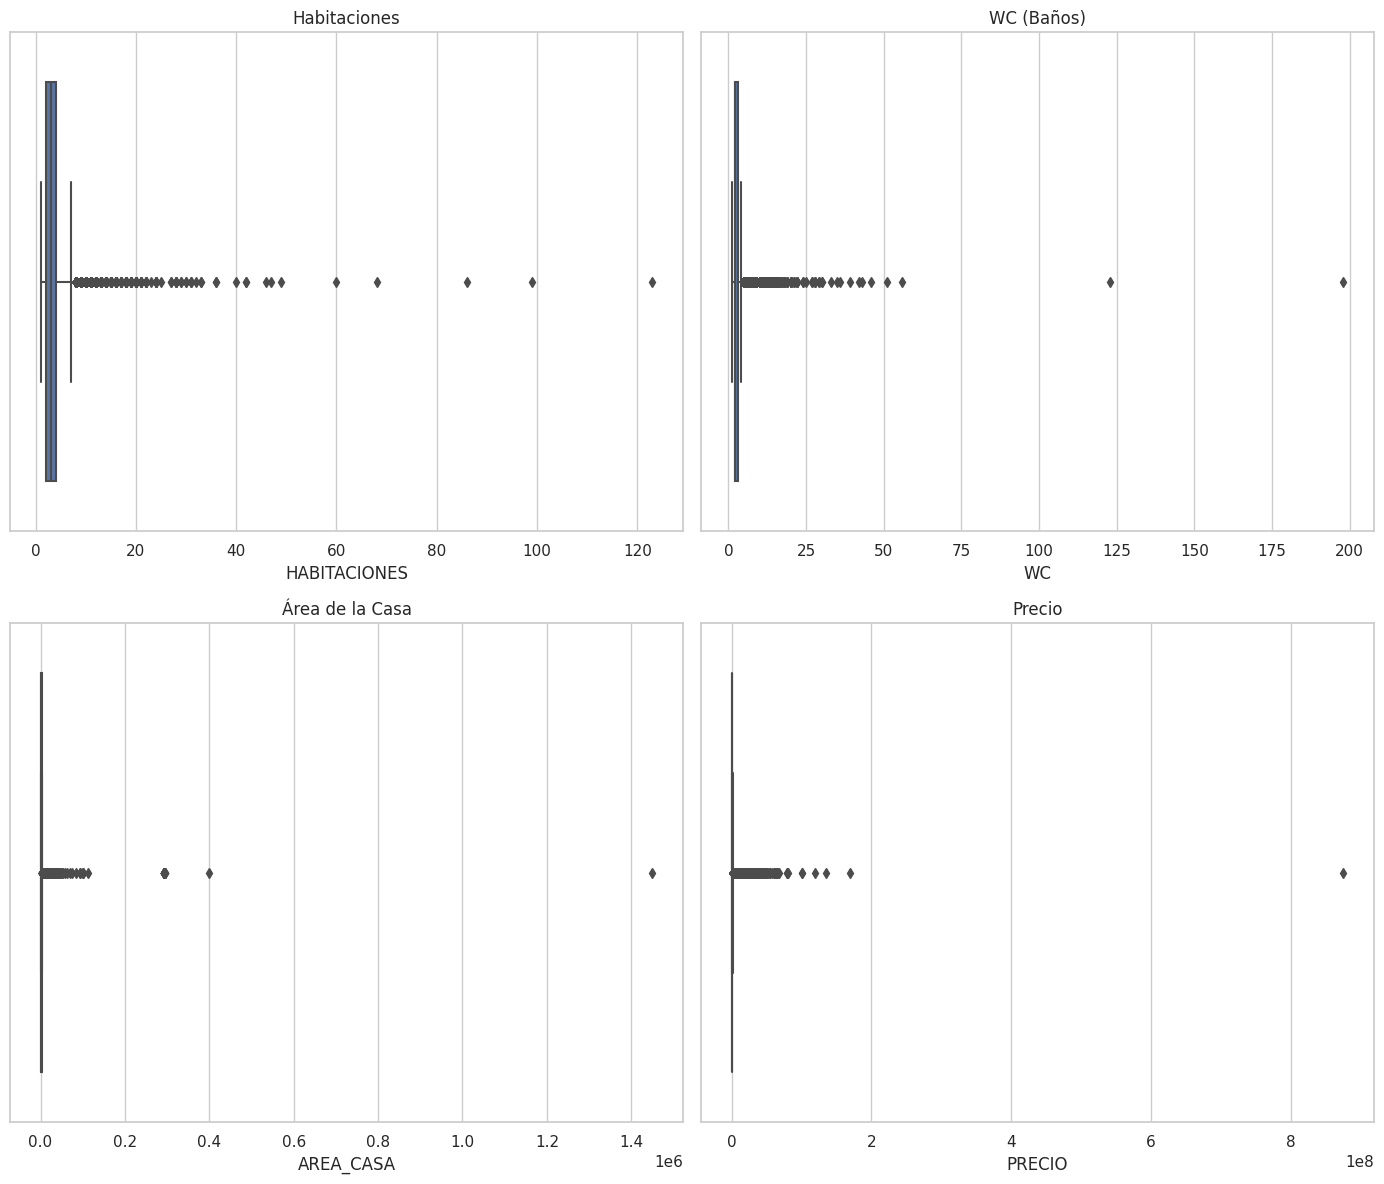

In [75]:
# Configurando el estilo de los gráficos
sns.set(style="whitegrid")

# Creando gráficos de caja para las variables numéricas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.boxplot(x=df_ol['HABITACIONES'], ax=axes[0, 0]).set_title('Habitaciones')
sns.boxplot(x=df_ol['WC'], ax=axes[0, 1]).set_title('WC (Baños)')
sns.boxplot(x=df_ol['AREA_CASA'], ax=axes[1, 0]).set_title('Área de la Casa')
sns.boxplot(x=df_ol['PRECIO'], ax=axes[1, 1]).set_title('Precio')

# Ajustando la disposición
plt.tight_layout()
plt.show()

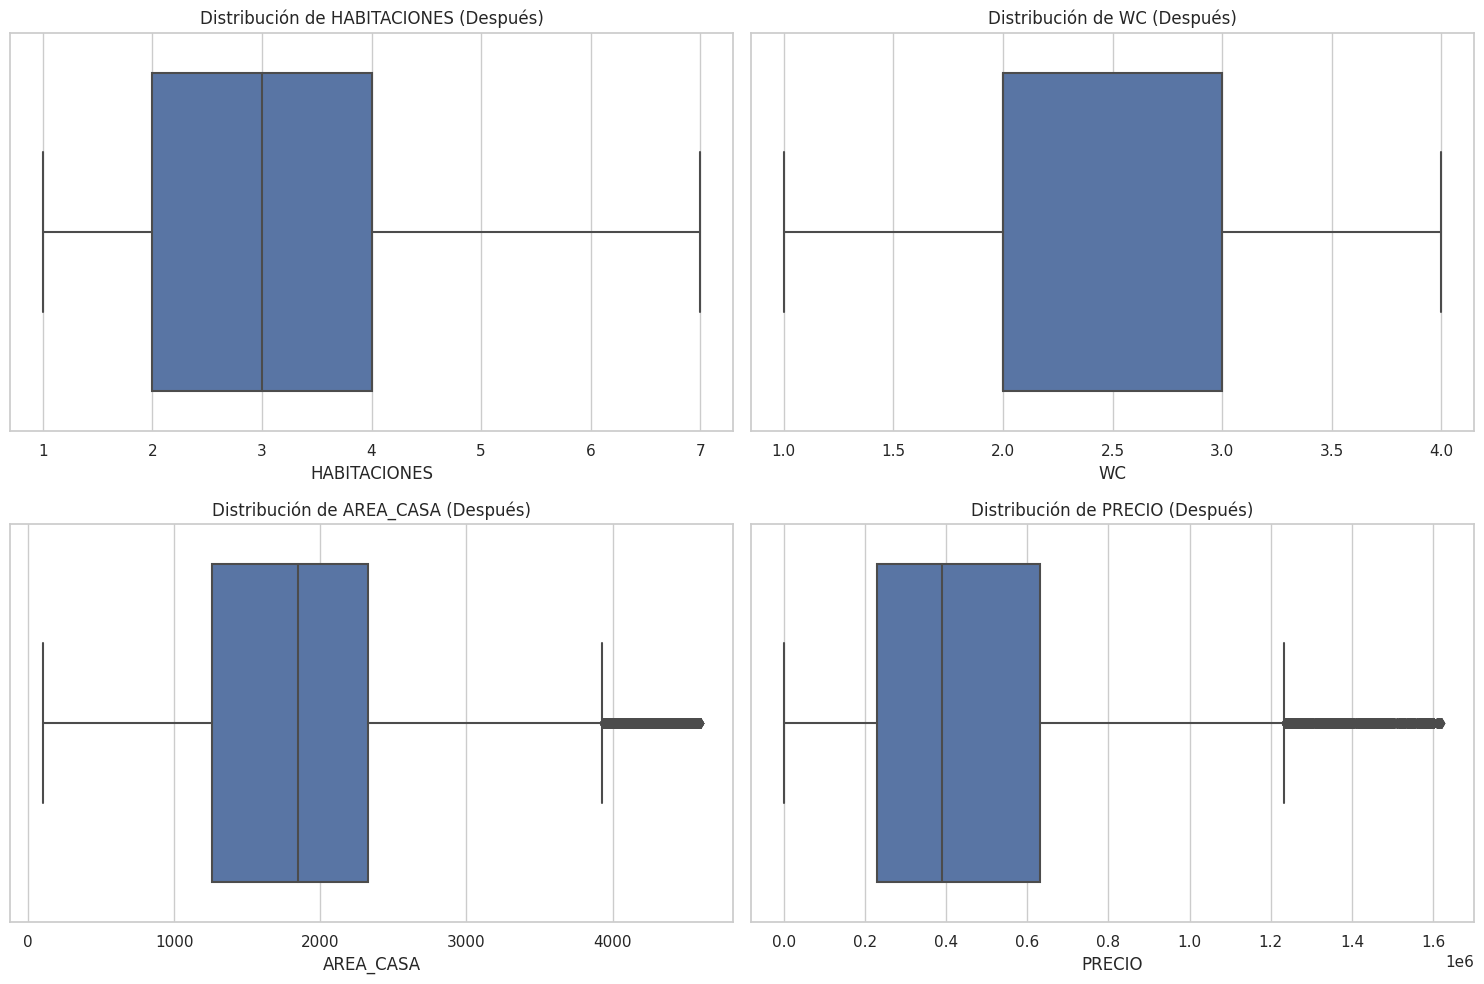

In [76]:
# Función para Identificar Valores Atípicos con el Método IQR
def valores_atipicos_iqr(datos):
    Q1 = datos.quantile(0.25)
    Q3 = datos.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (datos < limite_inferior) | (datos > limite_superior)

# Identificar Valores Atípicos en Variables Seleccionadas
variables_analizar = ['HABITACIONES', 'WC', 'AREA_CASA', 'PRECIO']
valores_atipicos = {}
for variable in variables_analizar:
    valores_atipicos[variable] = valores_atipicos_iqr(df_ol[variable])

# Eliminar Valores Atípicos
for variable in variables_analizar:
    df_ol = df_ol[~valores_atipicos[variable]]

# Gráficos del Después: Distribución de Variables
plt.figure(figsize=(15, 10))
for i, variable in enumerate(variables_analizar, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_ol[variable])
    plt.title(f'Distribución de {variable} (Después)')

plt.tight_layout()
plt.show()

In [77]:
# Contar la frecuencia de cada valor en la columna 'ESTADO'
conteo_estados = df_ol['ESTADO'].value_counts()

# Filtrar los registros cuya frecuencia de conteo sea inferior a 50
estados_a_eliminar = conteo_estados[conteo_estados < 50].index
df_ol = df_ol[~df_ol['ESTADO'].isin(estados_a_eliminar)]

# Reorganizamos el index
df_ol.index = np.arange(df_ol.index.size)

# Valores de ESTADO
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\nVALORES UNICOS DE LA COLUMNA ESTADO \n\n", df_ol['ESTADO'].unique())

# Valores de WC
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\nVALORES UNICOS DE LA COLUMNA WC \n\n", df_ol['WC'].unique())

# Valores de HABITACIONES
print('\n\033[96m' + '-' * 100 + '\033[0m\n',
      "\nVALORES UNICOS DE LA COLUMNA HABITACIONES \n\n", df_ol['WC'].unique(), "\n")

df_ol.head(20)

print("\n\n", "\033[1;36m" + "FRECUENCIA DE VENTAS POR ESTADO" + "\033[0m", "\n")
conteo_estados = df_ol['ESTADO'].value_counts()
conteo_estados


----------------------------------------------------------------------------------------------------
 
VALORES UNICOS DE LA COLUMNA ESTADO 

 ['Massachusetts' 'Maine' 'New York' 'New Hampshire' 'New Jersey'
 'Virgin Islands' 'Connecticut' 'Rhode Island' 'Vermont' 'Pennsylvania'
 'Puerto Rico' 'Delaware']

----------------------------------------------------------------------------------------------------
 
VALORES UNICOS DE LA COLUMNA WC 

 [3 2 1 4]

----------------------------------------------------------------------------------------------------
 
VALORES UNICOS DE LA COLUMNA HABITACIONES 

 [3 2 1 4] 



 FRECUENCIA DE VENTAS POR ESTADO 



New Jersey        27637
New York          20022
Connecticut       11956
Pennsylvania       8371
Massachusetts      8199
Maine              4402
New Hampshire      3105
Rhode Island       3012
Puerto Rico        2194
Vermont            2127
Delaware           1214
Virgin Islands      582
Name: ESTADO, dtype: int64

In [78]:
# Tomar los primeros 10000 registros
primeros_registros = df_ol.head(10000)

# Guardarlo en CSV
primeros_registros.to_csv('Dataset_Realtor.csv', index=False)



---

# **Análisis Exploratorio**


---





### DETERMINACIÓN SI LA VARIABLE AREA_LOTE INFLUYE EN EL PRECIO FINAL

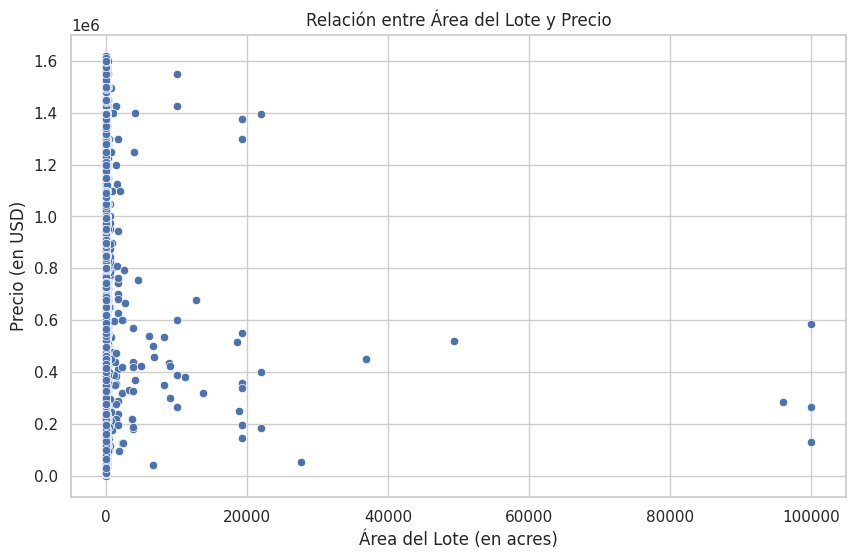

0.0008429760077543181

In [79]:
df_an = df_ol.copy()

# Diagrama de dispersión para visualizar la relación entre AREA_LOTE y PRECIO
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AREA_LOTE', y='PRECIO', data=df_an)
plt.title('Relación entre Área del Lote y Precio')
plt.xlabel('Área del Lote (en acres)')
plt.ylabel('Precio (en USD)')
plt.show()

# Calcular el coeficiente de correlación de Pearson
correlation = df_an['AREA_LOTE'].corr(df_an['PRECIO'])
correlation

El coeficiente de correlación de Pearson es aproximadamente -0.002, lo cual indica una correlación muy débil y cercana a cero entre el área del lote y el precio.

A continuación, ajustemos un modelo de regresión lineal para analizar esta relación más detalladamente y realizar una prueba de hipótesis para evaluar la significancia.

In [80]:
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Preparar las variables
X = df_an[['AREA_LOTE']]
X = sm.add_constant(X) # Añadir una constante para el término de intercepción
y = df_an['PRECIO']

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Resumen de los resultados del modelo, incluyendo la prueba de hipótesis para la pendiente
print(model.summary())
df_an.drop(["AREA_LOTE"], axis=1, inplace=True)



                            OLS Regression Results                            
Dep. Variable:                 PRECIO   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06596
Date:                Wed, 09 Aug 2023   Prob (F-statistic):              0.797
Time:                        03:11:54   Log-Likelihood:            -1.3111e+06
No. Observations:               92821   AIC:                         2.622e+06
Df Residuals:                   92819   BIC:                         2.622e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.674e+05   1082.771    431.715      0.0

Los resultados de la regresión lineal son los siguientes:

El coeficiente para el área del lote (AREA_LOTE) es -0,086 lo que significa que por cada acre adicional en el área del lote, el precio de la propiedad disminuye en promedio 0.08 USD.
El valor p para la prueba de hipótesis en la pendiente es 0.521, lo cual es mayor que el nivel de significancia comúnmente utilizado de 0.05
Esto significa que no hay evidencia suficiente para rechazar la hipótesis nula de que la pendiente es cero. En otras palabras, no hay evidencia de que el área del lote tenga un efecto significativo en el precio.
Además, el valor R2 es 0.000, lo que indica que el modelo no explica prácticamente ninguna de la variación en el precio.

En resumen, los análisis estadísticos no muestran una relación significativa entre el área del lote y el precio de las propiedades en este conjunto de datos. Por lo tanto, podemos concluir que el área del lote no parece ser una variable que influye en el precio final en este caso particular.

Se procede entonces a eliminar la variable AREA_LOTE y con ello se responde la primera pregunta

## **Análisis Univariado**

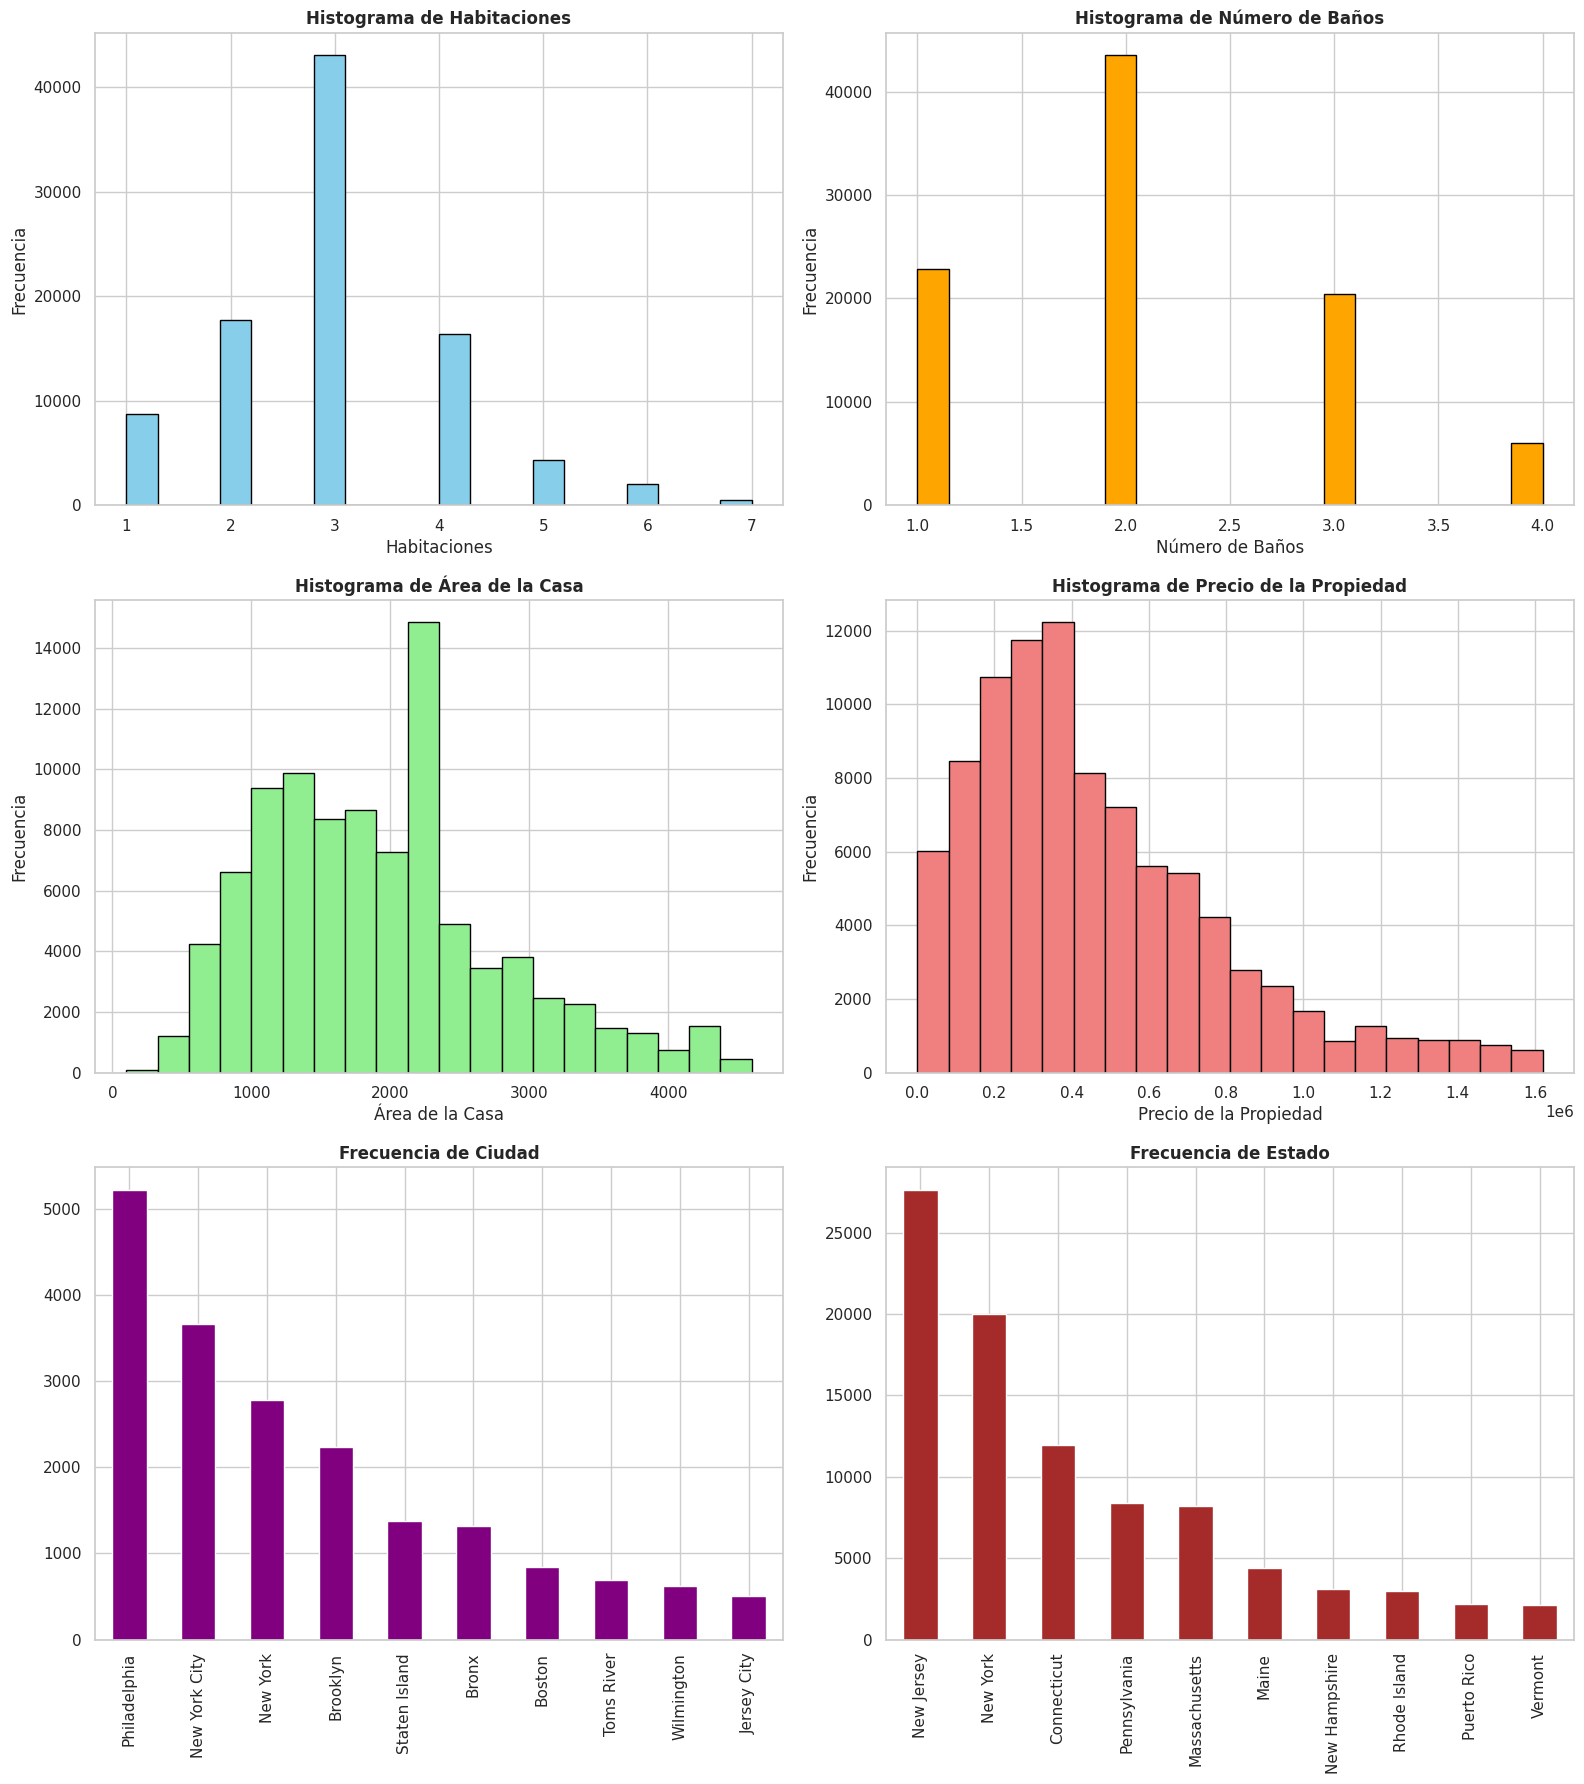



 ESTADÍSTICA DESCRIPTIVA 



,count,mean,std,min,25%,50%,75%,max
HABITACIONES,92821.0,2.981287,1.105424,1.0,2.0,3.0,4.0,7.0
WC,92821.0,2.104728,0.845695,1.0,2.0,2.0,3.0,4.0
AREA_CASA,92821.0,1919.146408,851.570637,100.0,1260.0,1845.0,2328.0,4600.0
PRECIO,92821.0,467454.279538,329809.702966,0.0,229000.0,389900.0,630000.0,1620000.0


In [81]:
# Creando una figura y ejes para organizar los gráficos en una cuadrícula
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Paleta de colores
colores = ['skyblue', 'orange', 'lightgreen', 'lightcoral', 'purple', 'brown']

# Función para crear histograma en una cuadrícula con colores y título en negrita
def histograma_grid_color(columna, ax, titulo, color):
    df_an[columna].plot(kind='hist', bins=20, edgecolor='black', ax=ax, color=color)
    ax.set_title(f'Histograma de {titulo}', fontweight='bold') # Título en negrita
    ax.set_xlabel(titulo)
    ax.set_ylabel('Frecuencia')

# Gráfico para "HABITACIONES"
histograma_grid_color('HABITACIONES', ax[0, 0], 'Habitaciones', colores[0])

# Gráfico para "WC"
histograma_grid_color('WC', ax[0, 1], 'Número de Baños', colores[1])

# Gráfico para "AREA_CASA"
histograma_grid_color('AREA_CASA', ax[1, 0], 'Área de la Casa', colores[2])

# Gráfico para "PRECIO"
histograma_grid_color('PRECIO', ax[1, 1], 'Precio de la Propiedad', colores[3])

# Gráfico para "CIUDAD" (10 ciudades más frecuentes) con título en negrita
df_an['CIUDAD'].value_counts().head(10).plot(kind='bar', ax=ax[2, 0], color=colores[4])
ax[2, 0].set_title('Frecuencia de Ciudad', fontweight='bold') # Título en negrita
# ... (resto del código sin cambios)

# Gráfico para "ESTADO" (10 estados más frecuentes) con título en negrita
df_an['ESTADO'].value_counts().head(10).plot(kind='bar', ax=ax[2, 1], color=colores[5])
ax[2, 1].set_title('Frecuencia de Estado', fontweight='bold') # Título en negrita


plt.tight_layout()
plt.show()


# Resumen estadístico consolidado en una tabla
print("\n\n", "\033[1;36m" + "ESTADÍSTICA DESCRIPTIVA" + "\033[0m", "\n")
resumen_estadistico = df_an[['HABITACIONES', 'WC', 'AREA_CASA', 'PRECIO']].describe()
df_describe.describe().T

###DISTRIBUCIÓN DE VENTAS POR ESTADO

In [82]:
# Contar la frecuencia de cada valor en la columna 'ESTADO'
conteo_estados = df_an['ESTADO'].value_counts()

palette=["#b30000", "#7c1158", "#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e", "#ebdc78", '#4A637D']
# crear el piechart
fig = px.pie(conteo_estados,
             values=conteo_estados.values,
             names=conteo_estados.index,
             title='DISTRIBUCION DE LAS VENTAS POR ESTADO',
             color_discrete_sequence=palette,
             height=500,
             width=800)
fig.update_layout(title={'x': 0.5, 'y': 0.95, 'xanchor': 'center', 'yanchor': 'top'}, showlegend=False)
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

print("\n\n", "\033[1;36m" + "FRECUENCIA DE VENTAS POR ESTADO" + "\033[0m", "\n")
conteo_estados



 FRECUENCIA DE VENTAS POR ESTADO 



New Jersey        27637
New York          20022
Connecticut       11956
Pennsylvania       8371
Massachusetts      8199
Maine              4402
New Hampshire      3105
Rhode Island       3012
Puerto Rico        2194
Vermont            2127
Delaware           1214
Virgin Islands      582
Name: ESTADO, dtype: int64

## **Analisis Bivariado**

### Prueba de Normalidad de la variable objetivo (Precio)

In [83]:
# Prueba de Test de Normalidad a Precio

test_normality(df_an['PRECIO'])

Variable: PRECIO
Hipotesis alternativa - La variable no se distribuye normalmente
p-value: 0.0000


###HEATMAP DE CORRELACIÓN DE VARIABLES

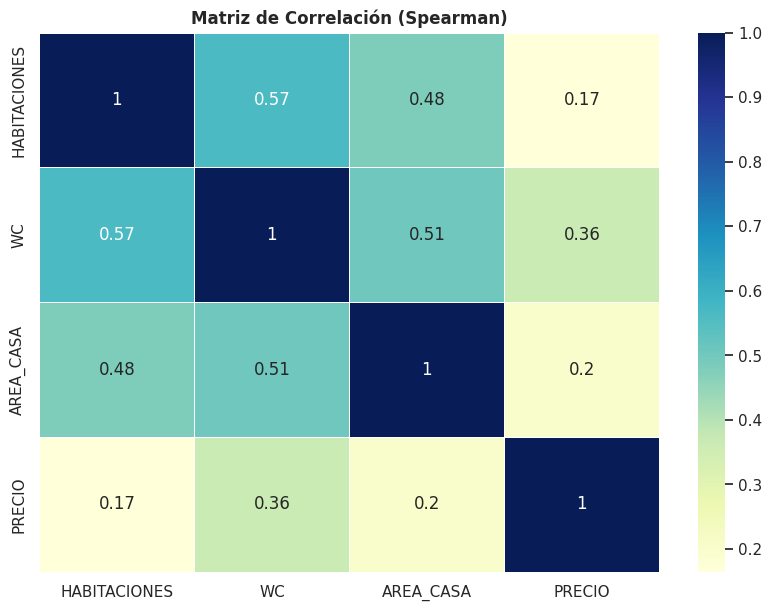

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, f_oneway

# Excluir la variable "ZIP_CODE" para el análisis
df_analisis = df_an.drop(columns=['ZIP_CODE'])

# Matriz de correlación utilizando Spearman
correlacion_spearman = df_analisis.corr(method='spearman')
plt.figure(figsize=(10, 7))
sns.heatmap(correlacion_spearman, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Matriz de Correlación (Spearman)', fontweight='bold')
plt.show()



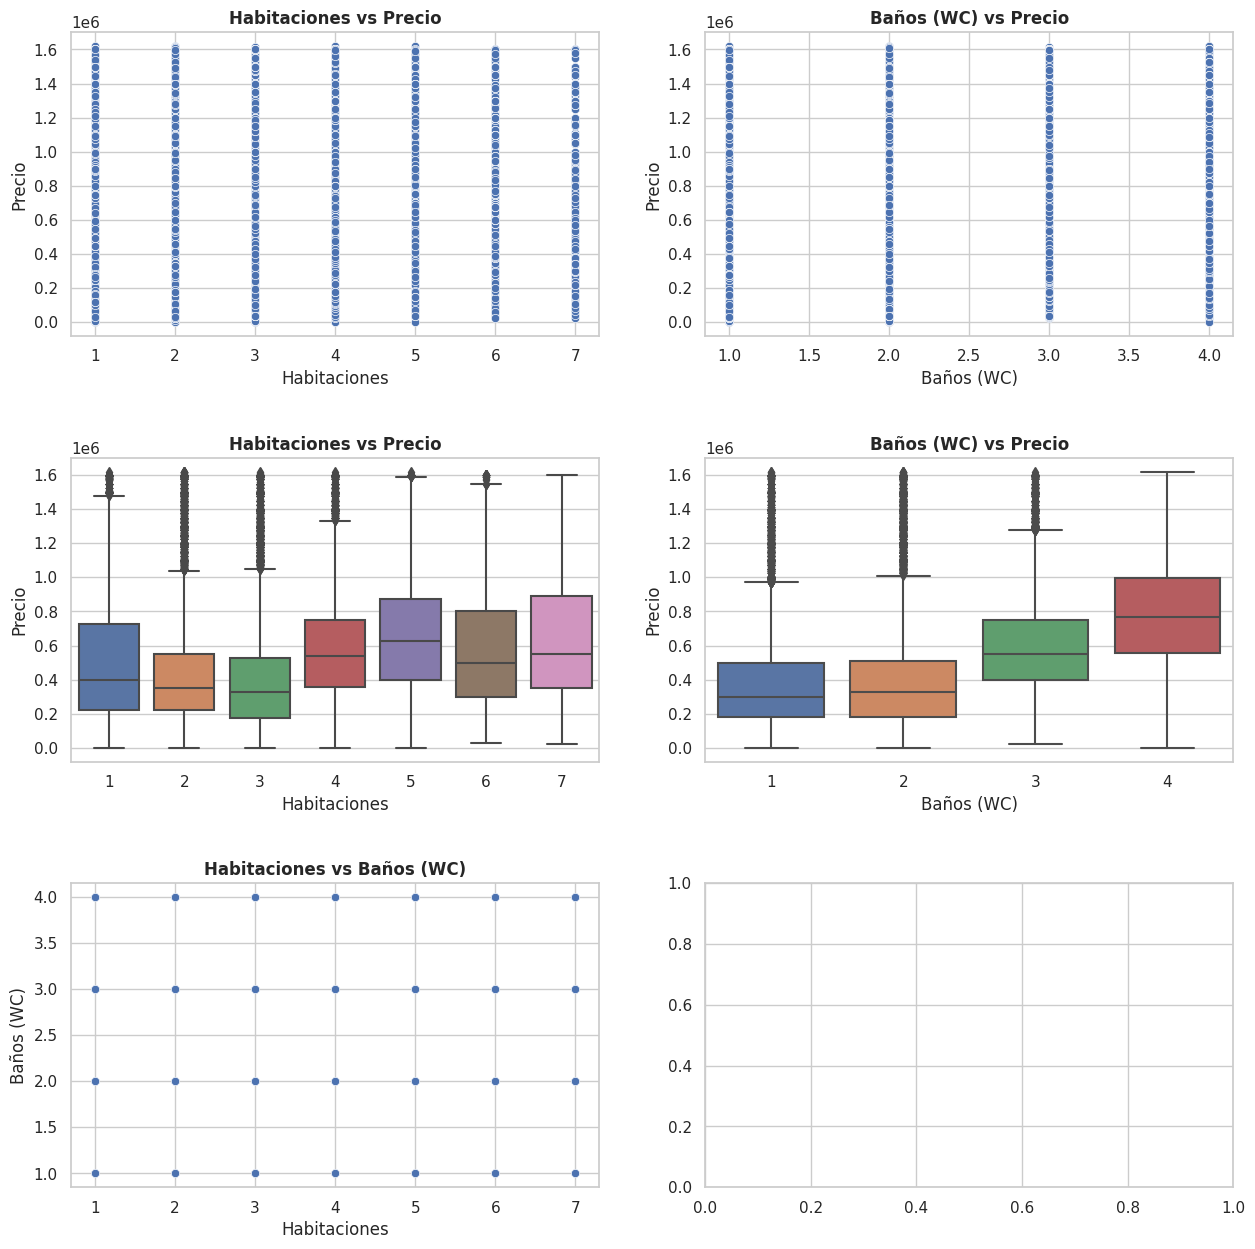

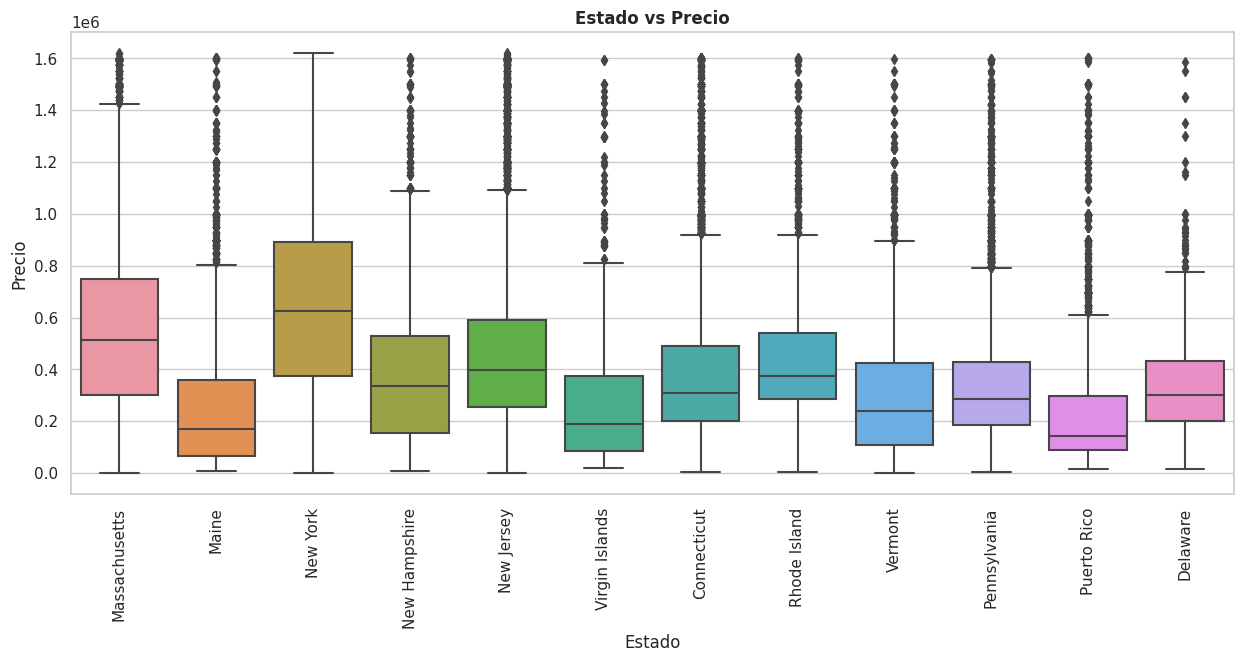

,Prueba,Estadístico,Valor p
0,"Correlación Spearman (PRECIO, HABITACIONES)",0.165058,0.000000e+00
1,"Correlación Spearman (PRECIO, WC)",0.363082,0.000000e+00
2,"Correlación Spearman (PRECIO, AREA_CASA)",0.197858,0.000000e+00
3,"Correlación Spearman (PRECIO, CIUDAD)",-0.027350,7.806340e-17
4,"Correlación Spearman (PRECIO, ESTADO)",0.067687,1.075736e-94
5,"Prueba ANOVA (ESTADO, PRECIO)",1457.291888,0.000000e+00


In [85]:
# Función para prueba de correlación de Spearman
def prueba_spearman(x, y):
    return spearmanr(x, y)

resultados_pruebas = {}
for columna in df_analisis.columns:
    if columna != 'PRECIO':
        resultado, p_valor = prueba_spearman(df_analisis[columna], df_analisis['PRECIO'])
        resultados_pruebas[f'Correlación Spearman (PRECIO, {columna})'] = (resultado, p_valor)

# Funciones para gráficos
def grafico_dispersion(x, y, titulo, xlabel, ylabel):
    sns.scatterplot(x=x, y=y)
    plt.title(titulo, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def boxplot(x, y, titulo, xlabel, ylabel):
    sns.boxplot(x=x, y=y)
    plt.title(titulo, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Gráficos de dispersión, boxplots y gráfico de barras con títulos en negrita
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.4)
plt.subplot(3, 2, 1)
grafico_dispersion(df_an['HABITACIONES'], df_an['PRECIO'], 'Habitaciones vs Precio', 'Habitaciones', 'Precio')
plt.subplot(3, 2, 2)
grafico_dispersion(df_an['WC'], df_an['PRECIO'], 'Baños (WC) vs Precio', 'Baños (WC)', 'Precio')
plt.subplot(3, 2, 3)
boxplot(df_an['HABITACIONES'], df_an['PRECIO'], 'Habitaciones vs Precio', 'Habitaciones', 'Precio')
plt.subplot(3, 2, 4)
boxplot(df_an['WC'], df_an['PRECIO'], 'Baños (WC) vs Precio', 'Baños (WC)', 'Precio')
plt.subplot(3, 2, 5)
grafico_dispersion(df_an['HABITACIONES'], df_an['WC'], 'Habitaciones vs Baños (WC)', 'Habitaciones', 'Baños (WC)')
plt.show()

plt.figure(figsize=(15, 6))
boxplot(df_an['ESTADO'], df_an['PRECIO'], 'Estado vs Precio', 'Estado', 'Precio')
plt.xticks(rotation=90)
plt.show()

# Prueba ANOVA para "ESTADO" vs "PRECIO"
grupos_estado = [df_an['PRECIO'][df_an['ESTADO'] == estado] for estado in df_an['ESTADO'].unique()]
resultado_anova_estado, p_valor_anova_estado = f_oneway(*grupos_estado)
resultados_pruebas['Prueba ANOVA (ESTADO, PRECIO)'] = (resultado_anova_estado, p_valor_anova_estado)

# Tabla con resultados
tabla_resultados = pd.DataFrame.from_dict(resultados_pruebas, orient='index', columns=['Estadístico', 'Valor p'])
tabla_resultados.index.name = 'Prueba'
tabla_resultados.reset_index(inplace=True)
tabla_resultados

## **Análisis Multivariado**

###ANÁLISIS DE LA RELACIÓN ENTRE EL PRECIO, LAS HABITACIONES Y LOS BAÑOS

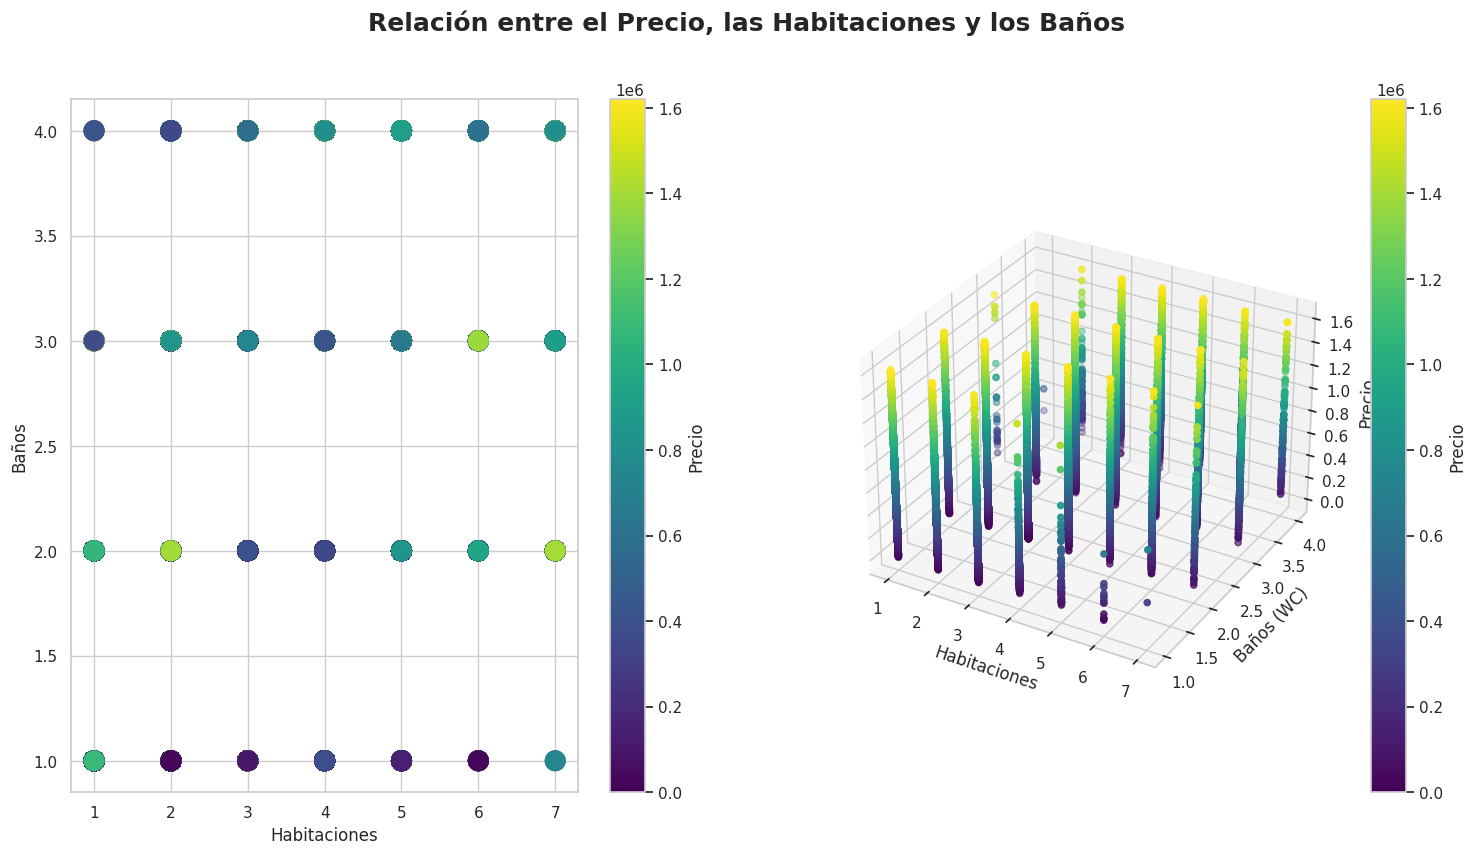

In [93]:
# Definición de las variables x, y, z para los gráficos
x = df_an['HABITACIONES']
y = df_an['WC']
z = df_an['PRECIO']

# Creación de una figura con un grid para los gráficos
fig = plt.figure(figsize=(18, 9))

# Scatter de Precio, Habitaciones y Baños (2D)
plt.subplot(1, 2, 1)
sc_2d = plt.scatter(x, y, c=z, s=200, cmap='viridis', marker='o') # usando círculos como marcadores
plt.xlabel("Habitaciones")
plt.ylabel("Baños")
plt.colorbar(sc_2d, label="Precio")

# Gráfico de dispersión 3D con gradiente de color basado en el precio
ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
sc_3d = ax_3d.scatter(x, y, z, c=z, marker='o', cmap='viridis') # usando círculos como marcadores
ax_3d.set_xlabel('Habitaciones')
ax_3d.set_ylabel('Baños (WC)')
ax_3d.set_zlabel('Precio')
plt.colorbar(sc_3d, ax=ax_3d, label='Precio')

# Título general para ambos gráficos
plt.suptitle('Relación entre el Precio, las Habitaciones y los Baños', fontsize=18, fontweight='bold')

plt.show()


###ANÁLISIS ANOVA POR ESTADO

In [88]:
pg.anova(data=df_an, dv="PRECIO", between="ESTADO", detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,ESTADO,1.487039e+15,11,1.351853e+14,1457.291888,0.0,0.147283
1,Within,8.609405e+15,92809,9.276476e+10,NaN,NaN,NaN


In [89]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Realizar la prueba post hoc de Tukey
tukey_resultado = pairwise_tukeyhsd(df_an['PRECIO'], df_an['ESTADO'])

# Convertir los resultados en un DataFrame
tukey_df = pd.DataFrame(data=tukey_resultado._results_table.data[1:], columns=tukey_resultado._results_table.data[0])

# Resaltar las filas con un valor p significativo
tukey_df['reject'] = tukey_df['p-adj'] < 0.05
tukey_df.style.apply(lambda x: ["background-color: red" if v else "" for v in x], axis=1, subset=['reject'])

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Connecticut,Delaware,-51730.043500,0.000000,-81713.097500,-21746.989500,True
1,Connecticut,Maine,-128435.544000,0.000000,-145983.737100,-110887.350900,True
2,Connecticut,Massachusetts,175994.196500,0.000000,161721.590400,190266.802600,True
3,Connecticut,New Hampshire,-4138.897300,0.999900,-24187.699200,15909.904600,False
4,Connecticut,New Jersey,65724.343500,0.000000,54828.619900,76620.067100,True
5,Connecticut,New York,280129.133300,0.000000,268624.726200,291633.540400,True
6,Connecticut,Pennsylvania,-43861.679300,0.000000,-58047.037100,-29676.321400,True
7,Connecticut,Puerto Rico,-130873.943900,0.000000,-153992.048900,-107755.839000,True
8,Connecticut,Rhode Island,57981.533900,0.000000,37688.511900,78274.555800,True
9,Connecticut,Vermont,-73358.484400,0.000000,-96782.220500,-49934.748200,True


---
# **Machine Learning**
---

In [94]:
df_ml = df_an.copy()

# Tomar los primeros 10000 registros
primeros_registros = df_an.head(10000)

# Guardarlo en CSV
primeros_registros.to_csv('Dataset_Realtor.csv', index=False)



df_ml.head(-20)

,HABITACIONES,WC,AREA_CASA,CIUDAD,ESTADO,ZIP_CODE,PRECIO
0,3,3,2498.000000,Auburn,Massachusetts,01501,779800.0
1,3,2,2836.400000,South Thomaston,Maine,04858,43000.0
2,1,1,2159.934538,New York,New York,10016,460000.0
3,3,3,2150.000000,Thornton,New Hampshire,03285,545000.0
4,3,2,1543.000000,Bronx,New York,10465,499999.0
...,...,...,...,...,...,...,...
92796,4,3,2750.000000,South Setauket,New York,11720,538000.0
92797,2,1,895.000000,New York City,New York,10023,1150000.0
92798,3,2,1259.000000,Springfield,Pennsylvania,19064,369900.0
92799,1,1,750.000000,New York City,New York,10128,450000.0


##Scaler y Encoder

In [95]:
# Prueba de Test de Normalidad a las variables

test_normality(df_ml['WC'])
test_normality(df_ml['HABITACIONES'])
test_normality(df_ml['AREA_CASA'])
test_normality(df_ml['PRECIO'])



Variable: WC
Hipotesis alternativa - La variable no se distribuye normalmente
p-value: 0.0000
Variable: HABITACIONES
Hipotesis alternativa - La variable no se distribuye normalmente
p-value: 0.0000
Variable: AREA_CASA
Hipotesis alternativa - La variable no se distribuye normalmente
p-value: 0.0000
Variable: PRECIO
Hipotesis alternativa - La variable no se distribuye normalmente
p-value: 0.0000


Como hay variables que no se distribuyen normalmente se optará por el Min-Max Scaler

In [96]:
# Copiar el dataset
dataset = df_ml.copy()

# Ajusta las opciones de visualización de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Seleccionar las columnas numéricas y categóricas
columnas_numericas = ['HABITACIONES', 'WC', 'AREA_CASA']
columnas_categoricas = ['CIUDAD', 'ESTADO', 'ZIP_CODE']

# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Escalar las variables numéricas
dataset[columnas_numericas] = scaler.fit_transform(dataset[columnas_numericas])

# Imprimir el dataset antes de la codificación
print('\n\033[93m' + '-' * 100 + '\033[0m\n',
      "\033[96m\nDATASET ANTES DE LA CODIFICACIÓN \n\n\033[0m", dataset, "\n")

# Crear un diccionario para almacenar el estado del LabelEncoder
estado_label_encoder = {}

# Codificar las variables categóricas y almacenar el estado del LabelEncoder
for columna in columnas_categoricas:
    encoder = LabelEncoder()
    dataset[columna] = encoder.fit_transform(dataset[columna])
    estado_label_encoder[columna] = encoder.classes_

# Imprimir el estado del LabelEncoder
print('\n\033[93m' + '-' * 100 + '\033[0m\n',
      "\033[96m\nESTADO DEL LABEL ENCODER \n\n\033[0m")
for columna, categorias in estado_label_encoder.items():
    print(f'Columna: {columna}')
    print(f'Categorías: {categorias}')
    print()

# Imprimir el dataset transformado
print('\n\033[93m' + '-' * 100 + '\033[0m\n',
      "\033[96m\nDATASET TRANSFORMADO \n\n\033[0m", dataset)



----------------------------------------------------------------------------------------------------
 
DATASET ANTES DE LA CODIFICACIÓN 

        HABITACIONES        WC  AREA_CASA           CIUDAD         ESTADO ZIP_CODE     PRECIO
0          0.333333  0.666667   0.532889           Auburn  Massachusetts    01501   779800.0
1          0.333333  0.333333   0.608089  South Thomaston          Maine    04858    43000.0
2          0.000000  0.000000   0.457763         New York       New York    10016   460000.0
3          0.333333  0.666667   0.455556         Thornton  New Hampshire    03285   545000.0
4          0.333333  0.333333   0.320667            Bronx       New York    10465   499999.0
...             ...       ...        ...              ...            ...      ...        ...
92816      0.333333  1.000000   0.533333     Conshohocken   Pennsylvania    19428   565000.0
92817      0.333333  0.000000   0.164889      Hormigueros    Puerto Rico    00660   100000.0
92818      0.500000  0.

## Regresión Lineal

### Regresión Lineal Multivariada

In [98]:
# Dividir el dataset en variables predictoras (X) y variable objetivo (y)
X = dataset.drop('PRECIO', axis=1)
y = dataset['PRECIO']

# Escalar las variables numéricas con MinMaxScaler
scaler = MinMaxScaler()
X[['HABITACIONES', 'WC', 'AREA_CASA']] = scaler.fit_transform(X[['HABITACIONES', 'WC', 'AREA_CASA']])

# Codificar las variables categóricas con LabelEncoder
label_encoder = LabelEncoder()
X['CIUDAD'] = label_encoder.fit_transform(X['CIUDAD'])
X['ESTADO'] = label_encoder.fit_transform(X['ESTADO'])
X['ZIP_CODE'] = label_encoder.fit_transform(X['ZIP_CODE'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Imprimir los coeficientes y el MSE
print("Coeficientes del modelo:")
for feature, coef in zip(X.columns, model.coef_):
    print(f'{feature}: {coef}')
print()
print(f"Error cuadrático medio (MSE): {mse}")
print()

# Agregar una constante para representar la intersección
X_train_const = sm.add_constant(X_train)

# Ajustar un modelo OLS utilizando statsmodels
ols_model = sm.OLS(y_train, X_train_const).fit()

# Imprimir el resumen del modelo
print(ols_model.summary())

Coeficientes del modelo:
HABITACIONES: -170118.51267408388
WC: 454575.6494145631
AREA_CASA: 67157.7577875263
CIUDAD: -11.59741669205141
ESTADO: 10395.737302194077
ZIP_CODE: 34.81128793058451

Error cuadrático medio (MSE): 93756527730.17198

                            OLS Regression Results                            
Dep. Variable:                 PRECIO   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     2019.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        03:40:13   Log-Likelihood:            -1.0433e+06
No. Observations:               74256   AIC:                         2.087e+06
Df Residuals:                   74249   BIC:                         2.087e+06
Df Model:                           6                                         
Covariance Type:            nonrobust           

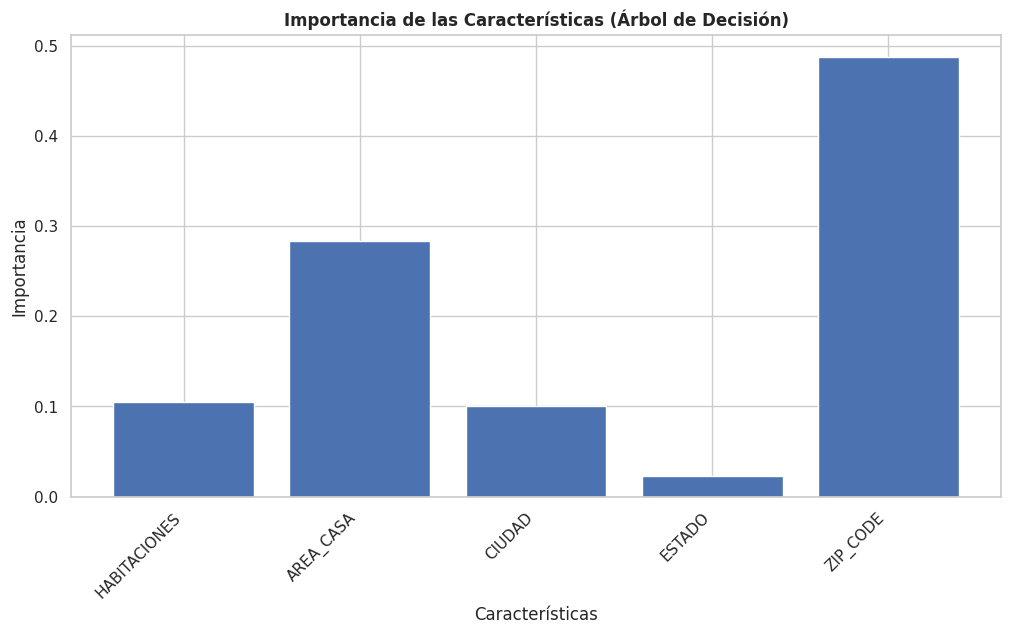

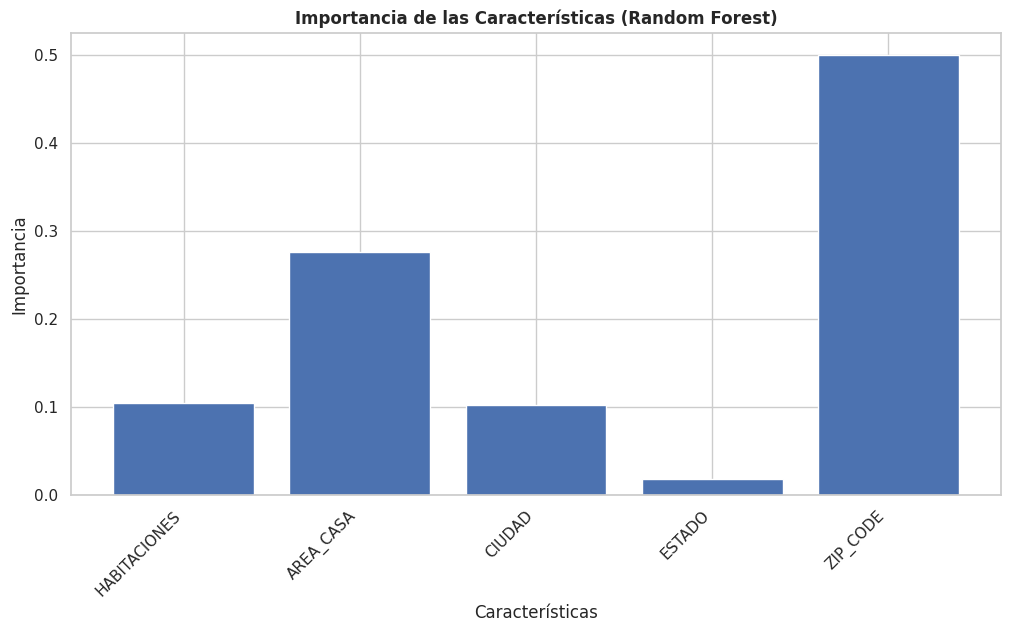

In [102]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Preparación de datos
categorical_columns = df_ml.select_dtypes(include=['object']).columns.tolist()
data_prepared = df_ml.copy()
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_prepared[column] = le.fit_transform(df_ml[column])
    label_encoders[column] = le
X = data_prepared.drop(columns=['PRECIO', 'WC'])
y = data_prepared['PRECIO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de Árbol de Decisión
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train_scaled, y_train)
y_pred_tree = decision_tree_model.predict(X_test_scaled)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Modelo de Random Forest
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train_scaled, y_train)
y_pred_forest = random_forest_model.predict(X_test_scaled)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_forest = r2_score(y_test, y_pred_forest)

# Modelo de Regresión Lineal
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_regression_model.predict(X_test_scaled)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Tabla resumen
summary_table = pd.DataFrame({
    'Modelo': ['Árbol de Decisión', 'Random Forest', 'Regresión Lineal'],
    'Error Cuadrático Medio (MSE)': [mse_tree, mse_forest, mse_linear],
    'Coeficiente de Determinación (R^2)': [r2_tree, r2_forest, r2_linear]
})

# Gráficas de importancia de características
def plot_feature_importance(importance, model_name):
    plt.figure(figsize=(12, 6))
    plt.bar(X.columns, importance)
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las Características ({model_name})', weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_feature_importance(decision_tree_model.feature_importances_, "Árbol de Decisión")
plot_feature_importance(random_forest_model.feature_importances_, "Random Forest")


In [103]:
# Agregando los valores a la tabla resumen
summary_table.loc[len(summary_table)] = ['Regresión Lineal', mse_linear, r2_linear]

# Mostrando la tabla resumen actualizada
summary_table

,Modelo,Error Cuadrático Medio (MSE),Coeficiente de Determinación (R^2)
0,Árbol de Decisión,6.569608e+10,0.396154
1,Random Forest,4.064455e+10,0.626415
2,Regresión Lineal,1.040502e+11,0.043622
3,Regresión Lineal,1.040502e+11,0.043622


In [108]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Preparación de datos
categorical_columns = df_ml.select_dtypes(include=['object']).columns.tolist()
data_prepared = df_ml.copy()
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_prepared[column] = le.fit_transform(df_ml[column])
    label_encoders[column] = le
X = data_prepared.drop(columns=['PRECIO', 'WC'])
y = data_prepared['PRECIO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimización del Árbol de Decisión
param_grid_tree = {'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [2, 5, 10]}
tree_model = DecisionTreeRegressor(random_state=42)
grid_search_tree = GridSearchCV(estimator=tree_model, param_grid=param_grid_tree,
                                cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search_tree.fit(X_train_scaled, y_train)

# Optimización de Random Forest
param_grid_forest = {'n_estimators': [5, 6], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
forest_model = RandomForestRegressor(random_state=42)
grid_search_forest = GridSearchCV(estimator=forest_model, param_grid=param_grid_forest,
                                  cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train_scaled, y_train)

# Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Evaluación de los Modelos Optimizados
best_tree_model = grid_search_tree.best_estimator_
y_pred_best_tree = best_tree_model.predict(X_test_scaled)
mse_best_tree = mean_squared_error(y_test, y_pred_best_tree)
r2_best_tree = r2_score(y_test, y_pred_best_tree)
best_forest_model = grid_search_forest.best_estimator_
y_pred_best_forest = best_forest_model.predict(X_test_scaled)
mse_best_forest = mean_squared_error(y_test, y_pred_best_forest)
r2_best_forest = r2_score(y_test, y_pred_best_forest)
y_pred_best_linear = linear_model.predict(X_test_scaled)
mse_best_linear = mean_squared_error(y_test, y_pred_best_linear)
r2_best_linear = r2_score(y_test, y_pred_best_linear)

# Tabla resumen con los valores de MSE y R^2
summary_table_optimized = pd.DataFrame({
    'Modelo': ['Árbol de Decisión (Optimizado)', 'Random Forest (Optimizado)', 'Regresión Lineal'],
    'Error Cuadrático Medio (MSE)': [mse_best_tree, mse_best_forest, mse_best_linear],
    'Coeficiente de Determinación (R^2)': [r2_best_tree, r2_best_forest, r2_best_linear]
})


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


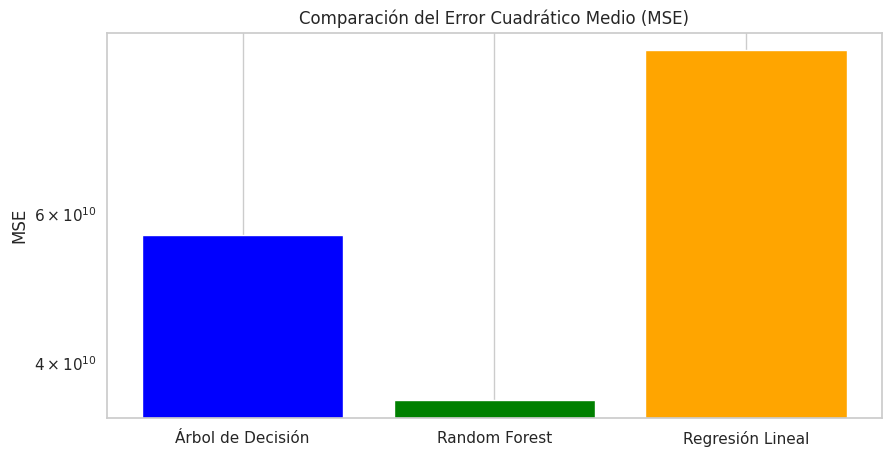

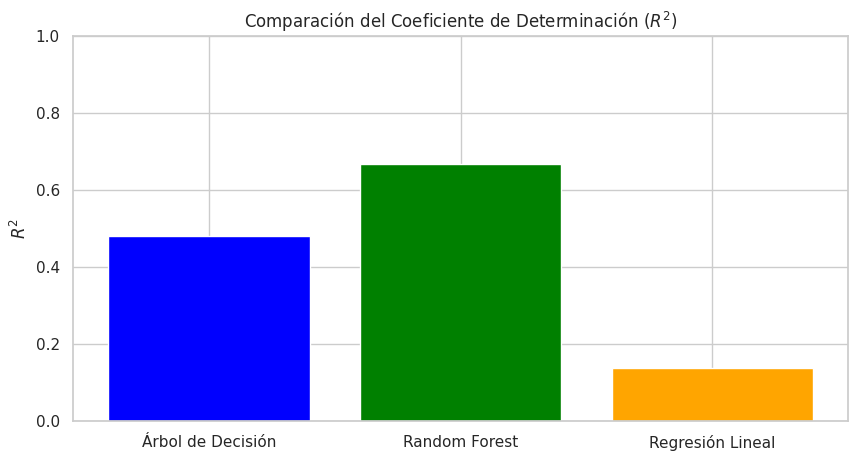

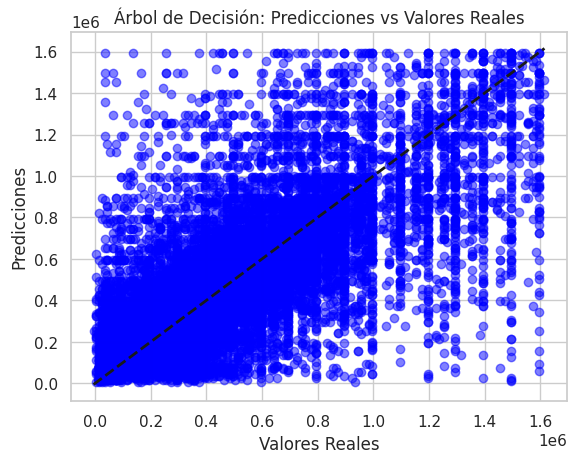

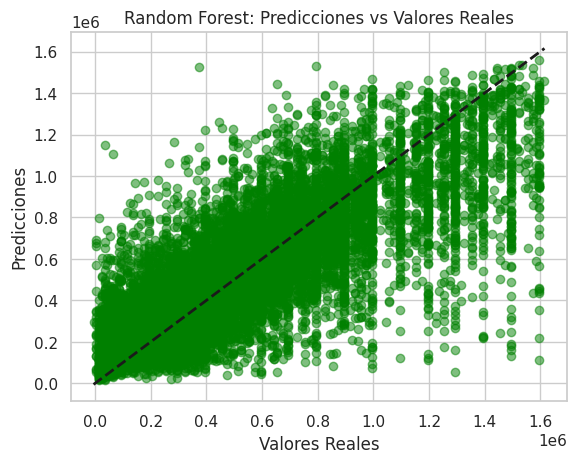

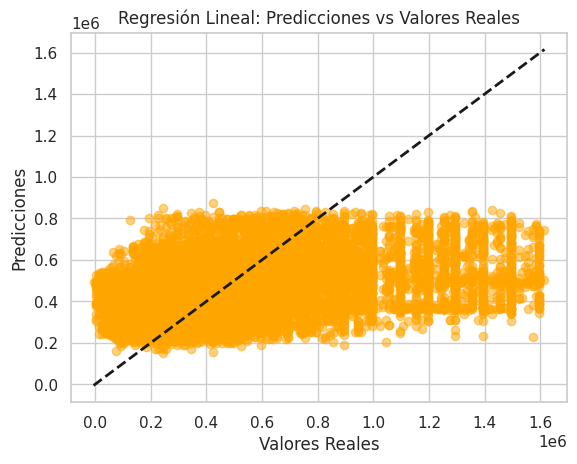

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Transformar las variables PRECIO y AREA_CASA
def round_to_category(value, step, offset=0):
    return round((value + offset) / step) * step - offset

df_ml['PRECIO'] = df_ml['PRECIO'].apply(lambda x: round_to_category(x, 10000, 5000))
df_ml['AREA_CASA'] = df_ml['AREA_CASA'].apply(lambda x: round_to_category(x, 100))

# Separar las características y la variable objetivo
X = df_ml.drop(columns=['PRECIO'])
y = df_ml['PRECIO']

# Aplicar LabelEncoder a las variables categóricas
label_encoders = {}
for column in ['CIUDAD', 'ESTADO', 'ZIP_CODE']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de Árbol de Decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train)
tree_predictions = tree_model.predict(X_test_scaled)
tree_mse = mean_squared_error(y_test, tree_predictions)

# Entrenar el modelo de Random Forest
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train_scaled, y_train)
forest_predictions = forest_model.predict(X_test_scaled)
forest_mse = mean_squared_error(y_test, forest_predictions)

# Entrenar el modelo de Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_predictions = linear_model.predict(X_test_scaled)
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Gráficos y visualizaciones (como se muestra anteriormente)
# Gráfico de barras para MSE
plt.figure(figsize=(10, 5))
plt.bar(['Árbol de Decisión', 'Random Forest', 'Regresión Lineal'], [tree_mse, forest_mse, linear_mse], color=['blue', 'green', 'orange'])
plt.title('Comparación del Error Cuadrático Medio (MSE)')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

# Gráfico de barras para R^2
plt.figure(figsize=(10, 5))
plt.bar(['Árbol de Decisión', 'Random Forest', 'Regresión Lineal'], [r2_score(y_test, tree_predictions), r2_score(y_test, forest_predictions), linear_r2], color=['blue', 'green', 'orange'])
plt.title('Comparación del Coeficiente de Determinación ($R^2$)')
plt.ylabel('$R^2$')
plt.ylim(0, 1)
plt.show()

# Función para graficar las predicciones vs los valores reales
def plot_predictions(predictions, title, color):
    plt.scatter(y_test, predictions, color=color, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(title)
    plt.show()

# Gráfico de las predicciones del Árbol de Decisión
plot_predictions(tree_predictions, 'Árbol de Decisión: Predicciones vs Valores Reales', 'blue')

# Gráfico de las predicciones del Random Forest
plot_predictions(forest_predictions, 'Random Forest: Predicciones vs Valores Reales', 'green')

# Gráfico de las predicciones de la Regresión Lineal
plot_predictions(linear_predictions, 'Regresión Lineal: Predicciones vs Valores Reales', 'orange')